In [1]:
import os
os.chdir("/data/t-achetan/adv_geom/src")


In [2]:
debug=True

In [3]:
import os
import sys

# sys.path.insert(1, os.path.dirname(os.path.realpath(__file__)) + '/../')
import argparse

import numpy as np

import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader

from matplotlib.colors import LinearSegmentedColormap

from datagen.synthetic.single import sphere, swissroll
from datagen.synthetic.multiple import intertwinedswissrolls, wellseparatedspheres, concentricspheres

from expC.expC_utils.common import *
from expC.expC_utils import plot_ittwswrolls

MFLD_TYPES = {
    "single-sphere": sphere.RandomSphere,
    "single-swissroll": swissroll.RandomSwissRoll,
    "ittw-swissrolls": intertwinedswissrolls.IntertwinedSwissRolls,
    "inf-ittw-swissrolls": intertwinedswissrolls.IntertwinedSwissRolls,
    "inf-ws-spheres": wellseparatedspheres.WellSeparatedSpheres,
    "inf-conc-spheres": concentricspheres.ConcentricSpheres
}

MFLD_VIZ_BY_TYPE = {
    "ittw-swissrolls": plot_ittwswrolls,
    "inf-ittw-swissrolls": plot_ittwswrolls,
    "inf-ws-spheres": plot_ittwswrolls,
    "inf-conc-spheres": plot_ittwswrolls

}

18-05-2022 22:15:33 -- [I] faiss.loader >> Loading faiss with AVX2 support.
18-05-2022 22:15:34 -- [I] faiss.loader >> Successfully loaded faiss with AVX2 support.


In [4]:
# use = (
#     ('red', "pink"),
#     ('blue', "lightsteelblue"),
#     ('gold', "yellow")
# )

use = (
    ('darkred', "coral"),
    ('navy', "cornflowerblue"),
    ('gold', "palegreen")
)

cm_1_dl = LinearSegmentedColormap.from_list('use1dl', [u[0] for u in use[:-1]], N=len(use[:-1]))
cm_2_dl = LinearSegmentedColormap.from_list('use2dl', [u[1] for u in use], N=len(use))

cm_1_sc = LinearSegmentedColormap.from_list('use1sc', [u[0] for u in use[:-1]], N=len(use[:-1]))
cm_2_sc = LinearSegmentedColormap.from_list('use2sc', [u[1] for u in use[:-1]], N=len(use[:-1]))



In [5]:
def get_nplane_samples_for_kmfld_2(k_dim_samples, dataset, n=3, h=800):
    """
    returns samples from n-dim plane containing the manifold

    :param k_dim_samples: k-dim embeddings of the points. assume k=2
    :type k_dim_samples: torch.Tensor
    :param dataset: dataset object to get necessary transforms
    :type dataset: torch.util.data.Dataset
    :param n: the dimension of the space in which the plane will be
    :type n: int
    :param num_samples: number of samples to generate
    :type num_samples:: int
    """
    k = k_dim_samples.shape[1]
    if type(k_dim_samples) == torch.Tensor:
        k_dim_samples = k_dim_samples.numpy()
    
    low = (1 - np.sign(np.min(k_dim_samples)) * 0.1) * np.min(k_dim_samples) 
    high = (1 + np.sign(np.max(k_dim_samples)) * 0.1) * np.max(k_dim_samples)
    x_min = low
    y_min = low
    x_max = high
    y_max = high
    if isinstance(dataset, concentricspheres.ConcentricSpheres):
        x_min, x_max = np.min(k_dim_samples[:, 0]) * (1 - np.sign(np.min(k_dim_samples[:, 0])) * 0.1), np.max(k_dim_samples[:, 0]) * (1 + np.sign(np.max(k_dim_samples[:, 0])) * 0.1)
        y_min, y_max = np.min(k_dim_samples[:, 1]) * (1 - np.sign(np.min(k_dim_samples[:, 1])) * 0.1), np.max(k_dim_samples[:, 1]) * (1 + np.sign(np.max(k_dim_samples[:, 1])) * 0.1)
    
    
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min) / h),\
                      np.arange(y_min, y_max, (y_max - y_min) / h))
    print(xx.shape, yy.shape)
    gen_kd_grid = np.zeros((h * h, 2))
    gen_kd_grid[:, 0] = xx.ravel()
    gen_kd_grid[:, 1] = yy.ravel()
                         
    print(gen_kd_grid.shape)

    num_samples = gen_kd_grid.shape[0]
    gen_nd_grid = np.zeros((num_samples, n))

    accessor = dataset
    if isinstance(dataset, manifold.Manifold):
        accessor = dataset.genattrs

    gen_nd_grid[:, :k] = gen_kd_grid
    gen_nd_grid = gen_nd_grid + accessor.translation
    rotation = accessor.rotation
    if len(accessor.rotation.shape) == 3 and accessor.rotation.shape[0] == 2:
        rotation = accessor.rotation[0]
    gen_nd_grid = np.dot(rotation, gen_nd_grid.T).T
    gen_nd_grid = gen_nd_grid / accessor.norm_factor
    gen_nd_grid = torch.from_numpy(gen_nd_grid).float()
    gen_nd_grid = gen_nd_grid - accessor.anchor + accessor.fix_center

    gen_kd_grid = torch.from_numpy(gen_kd_grid).float()
    gen_nd_grid = gen_nd_grid.float()

    return xx, yy, gen_kd_grid, gen_nd_grid

In [6]:
def make_plots_2(model, dataset, dump_dir, task="regression",\
     batch_size=8192, num_workers=8, cuda=1, plot_type="contour", thresh=None, h=250, num_samples=50000):

    # intertwined swiss rolls are planar swiss rolls
    # so we will proceed as such
    n = 0
    k = 0
    if isinstance(dataset, manifold.Manifold):
        n = dataset.genattrs.n
        k = dataset.genattrs.k
        if thresh is None:
            thresh = dataset.genattrs.D / dataset.genattrs.norm_factor
    else:
        n = dataset.n
        k = dataset.k
        if thresh is None:
            thresh = dataset.S1.genattrs.D / dataset.norm_factor

    points_k = get_coplanar_kdim_samples(dataset)
    points_k_classes = dataset.class_labels[dataset.class_labels != 2]
    
    xx = 1
    yy = None
    gen_kd_grid = None
    gen_nd_grid = None
    dummy_labels = None
    
    num_classes = model.output_size
    
    if debug:
    
        gen_kd_grid = torch.load("{}_gen_kd_grid.pth".format(task))
        gen_nd_grid = torch.load("{}_gen_nd_grid.pth".format(task))

    if not debug:
        if plot_type == "contour":
            xx, yy, gen_kd_grid, gen_nd_grid = get_nplane_samples_for_kmfld_2(points_k, dataset, n, h)
            dummy_labels = torch.from_numpy(np.zeros((h * h, num_classes))).float()
        elif plot_type == "sct":
            gen_kd_grid, gen_nd_grid = get_nplane_samples_for_kmfld(points_k, dataset, n, num_samples)
            dummy_labels = torch.from_numpy(np.zeros((num_samples, num_classes))).float()
    
    
        torch.save(gen_kd_grid, "{}_gen_kd_grid.pth".format(task))
        torch.save(gen_nd_grid, "{}_gen_nd_grid.pth".format(task))
    
    if debug:
        if plot_type == "contour":
            dummy_labels = torch.from_numpy(np.zeros((h * h, num_classes))).float()
        else:
            dummy_labels = torch.from_numpy(np.zeros((num_samples, num_classes))).float()

    if task == "clf":
        dummy_labels = dummy_labels[:, 0].long()

    gen_nd_dataset = TensorDataset(gen_nd_grid, dummy_labels)

    gen_nd = DataLoader(dataset=gen_nd_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

    device = torch.device("cuda:{}".format(cuda) if torch.cuda.is_available() and cuda is not None else "cpu")
    
    if not debug:
        _, _, _, gen_nd_logits = lmd.test(model, gen_nd, device, task=task, debug=False)
        print("inference done")
        torch.save(gen_nd_logits, "{}_gen_nd_logits.pth".format(task))
    
    
    gen_nd_logits = torch.load("{}_gen_nd_logits.pth".format(task))
    
    gen_pred_classes = None
    if task == "clf":
        gen_pred_classes = torch.max(gen_nd_logits, axis=1)[1]
    elif task == "regression":
        gen_pred_classes = torch.min(gen_nd_logits, axis=1)[1]
    
    
    return xx, yy, h, gen_kd_grid, points_k, points_k_classes, gen_nd_grid, gen_pred_classes, gen_nd_logits, dataset, thresh, task, dump_dir



def plot_decision_regions_2(xx, yy, h, gen_kd_grid, points_k, points_k_classes,\
     gen_nd_grid, gen_pred_classes, gen_nd_logits, dataset, thresh, task, dump_dir, ax, plot_type="contour"):



    plotdir = "./"

    THRESH = thresh
    OFF_MFLD_LABEL = torch.max(gen_pred_classes) + 1

    k = points_k.shape[1]
    n = gen_nd_grid.shape[1]
    if k not in [2, 3]:
        raise RuntimeError("decision region visualization not possible")

    if task == "regression": gen_pred_classes[torch.min(gen_nd_logits, axis=1)[0] >= THRESH] = OFF_MFLD_LABEL
    col = ["red", "blue", "yellow"]
    
    if len(np.unique(gen_pred_classes)) > 2:
        print(np.unique(gen_pred_classes))
        cm_1 = cm_1_dl
        cm_2 = cm_2_dl
    else:
        cm_1 = cm_1_sc
        cm_2 = cm_2_sc
    
    if k == 2:

        if plot_type == "contour":
            ax.contourf(xx, yy, gen_pred_classes.reshape(xx.shape), cmap=cm_2, alpha=0.8)


            ax.scatter(gen_kd_grid[:, 0], gen_kd_grid[:, 1], c=gen_pred_classes, cmap=cm_2, s=0.01)
            ax.scatter(points_k[:, 0], points_k[:, 1], c=points_k_classes, cmap=cm_1, s=0.1)
        else:
            add_to_idx = 0
            if isinstance(dataset, concentricspheres.ConcentricSpheres):
                add_to_idx = -1
            ax.scatter(gen_kd_grid[:, 0 + add_to_idx], gen_kd_grid[:, 1 + add_to_idx], c=gen_pred_classes, cmap=cm_2, s=0.05)
            ax.scatter(points_k[:, 0 + add_to_idx], points_k[:, 1 + add_to_idx], c=points_k_classes, cmap=cm_1, s=0.1)

    



In [7]:
def plot_distance_heatmap(xx, yy, h, gen_kd_grid, points_k, points_k_classes,\
     gen_nd_grid, gen_pred_classes, gen_nd_logits, dataset, thresh, task, dump_dir, axs, plot_type="contour"):



    plotdir = "./"

    THRESH = thresh
    OFF_MFLD_LABEL = torch.max(gen_pred_classes) + 1

    k = points_k.shape[1]
    n = gen_nd_grid.shape[1]
    if k not in [2, 3]:
        raise RuntimeError("decision region visualization not possible")

    if task == "regression": gen_pred_classes[torch.min(gen_nd_logits, axis=1)[0] >= THRESH] = OFF_MFLD_LABEL
    col = ["red", "blue", "yellow"]
    
    if len(np.unique(gen_pred_classes)) > 2:
        print(np.unique(gen_pred_classes))
        cm_1 = cm_1_dl
        cm_2 = cm_2_dl
    else:
        cm_1 = cm_1_sc
        cm_2 = cm_2_sc
    
    if k == 2:
        i = 0
        ax = axs
        if plot_type == "contour":
            ax.contourf(xx, yy, gen_nd_logits[:, i].reshape(xx.shape), cmap=cm_2, alpha=0.8)


            ax.scatter(gen_kd_grid[:, 0], gen_kd_grid[:, 1], c=gen_nd_logits[:, i], cmap="hot", s=0.05)
            ax.scatter(points_k[:, 0][points_k_classes == i], points_k[:, 1][points_k_classes == i], c=["orange", "cyan"], s=0.1)
        else:
            limit=0.5
            add_to_idx = 0
            if isinstance(dataset, concentricspheres.ConcentricSpheres):
                add_to_idx = -1
            sc = ax.scatter(gen_kd_grid[:, 0 + add_to_idx][gen_nd_logits[:, i] < limit], gen_kd_grid[:, 1 + add_to_idx][gen_nd_logits[:, i] < limit], c=gen_nd_logits[:, i][gen_nd_logits[:, i] < limit], cmap="autumn", s=0.05, vmin = 0, vmax =limit)
            ax.scatter(points_k[:, 0 + add_to_idx], points_k[:, 1 + add_to_idx], c=points_k_classes, cmap=cm_1, s=1)

    
    return sc


In [8]:
def run_analysis_2(dl_dump_dir, stdclf_dump_dir, on="test", h=800, thresh=None, plot_type="contour", num_samples=50000, plot_name="test"):
    
    
    
    
    if on not in ["train", "test", "val"]:
        raise RuntimeError("`on` can only be one of 'train', 'test', 'val'")

    config_dict = load_config(dl_dump_dir)
    task = config_dict["task"]
    model = load_model(dl_dump_dir)
    data_dir = os.path.join(dl_dump_dir, "../data")
    data_mfld_type = config_dict["data"]["mtype"]

#     train_set, val_set, test_set = MFLD_TYPES[data_mfld_type].load_splits(data_dir)
    
    fig_size = (9, 4)
    if data_mfld_type == "inf-ws-spheres":
        fig_size = (13, 4)
    fig, ax_array = plt.subplots(1, 2, figsize=fig_size)
    
    data_set = MFLD_TYPES[data_mfld_type]()
    data_set.load_data(os.path.join(data_dir, on))
    
#     data_set = val_set if on == "val" else test_set

    # plot figure 1
    xx, yy, h, gen_kd_grid, points_k, points_k_classes, gen_nd_grid, gen_pred_classes, gen_nd_logits, dataset, thresh, task, dump_dir = make_plots_2(model, data_set, dl_dump_dir, task, h=h, plot_type=plot_type, num_samples=num_samples, thresh=thresh)

    plot_decision_regions_2(xx, yy, h, gen_kd_grid, points_k, points_k_classes, gen_nd_grid,\
                            gen_pred_classes, gen_nd_logits, dataset, thresh, task, dump_dir, ax_array[0], plot_type)
    
    fig_size2 = (5, fig_size[1])
    if data_mfld_type == "inf-ws-spheres":
        fig_size2 = (7, 4)
    fig2, ax_array2 = plt.subplots(1, 1, figsize=fig_size2)
        
    sc = plot_distance_heatmap(xx, yy, h, gen_kd_grid, points_k, points_k_classes, gen_nd_grid, gen_pred_classes, gen_nd_logits, dataset, thresh, "regression", dump_dir, ax_array2, plot_type)

    
    fig2.colorbar(sc, ax=ax_array2)
#     plt.clim(vmin=0, vmax=data_set.max_norm / dataset.norm_factor);
#     ax_array2.set_title("predicted heat map")
    
    fig2.suptitle(r"$m=1, n={}$".format(gen_nd_grid.shape[1]))
    fig2.savefig('disthmap_{}_{}.png'.format(plot_name, plot_type), dpi=300)
    fig2.savefig('disthmap_{}_{}.pdf'.format(plot_name, plot_type), dpi=300)
    fig2.savefig('disthmap_{}_{}.svg'.format(plot_name, plot_type), dpi=300)
#     plt.show()
    
    
    dl_data_dir = data_dir
    data_dir = os.path.join(dump_dir, "../data")
    config_dict = load_config(stdclf_dump_dir)
    task = config_dict["task"]
    model = load_model(stdclf_dump_dir)
    
    
    
    if data_dir != dl_data_dir:
        data_mfld_type = config_dict["data"]["mtype"]
        train_set, val_set, test_set = MFLD_TYPES[data_mfld_type].load_splits(data_dir)

        data_set = val_set if on == "val" else test_set
    
#     points_k_class_dl = points_k_classes
#     gen_nd_grid_dl = gen_nd_grid.clone()
#     points_k_classes_dl = points_k_classes.clone()
#     gen_pred_classes_dl = gen_pred_classes.clone()
#     gen_nd_logits_dl = gen_nd_logits.clone()
    
    
    
    xx, yy, h, gen_kd_grid, points_k, points_k_classes, gen_nd_grid, gen_pred_classes, gen_nd_logits, dataset, thresh, task, dump_dir = make_plots_2(model, data_set, stdclf_dump_dir, task, h=h, plot_type=plot_type, num_samples=num_samples, thresh=thresh)
    print(xx is None)
    plot_decision_regions_2(xx, yy, h, gen_kd_grid, points_k, points_k_classes, gen_nd_grid,\
                            gen_pred_classes, gen_nd_logits, dataset, thresh, task, dump_dir, ax_array[1], plot_type)
    fig.suptitle(r"$m=1, n={}$".format(gen_nd_grid.shape[1]))
#     plt.tight_layout()

    fig.savefig('decreg_{}_{}.png'.format(plot_name, plot_type), dpi=300)
    fig.savefig('decreg_{}_{}.pdf'.format(plot_name, plot_type), dpi=300)
    fig.savefig('decreg_{}_{}.svg'.format(plot_name, plot_type), dpi=300)
    plt.show()
    
    

In [9]:
# Swiss Roll k=2, n=500 (VM1)
# dl_dump = "/mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_swrolls_test/rdm_swrolls_k2n500_noninfdist_moreoffmfld__bs4096_inferred_maxtdelta=1e=3/2"
# stdclf_dump = "/mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_swrolls_test/rdm_swrolls_k2n500_noninfdist_moreoffmfld__bs4096_inferred_maxtdelta=1e=3/4"
# plot_name = "sw_k2n500"




In [10]:
# Swiss Roll k=2, n=2 (VM1)
# dl_dump = "/mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_swrolls_test/rdm_swrolls_k2n2_noninfdist_moreoffmfld_inferred_maxtdelta=1e=3/1"
# stdclf_dump = "/mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_swrolls_test/rdm_swrolls_k2n2_noninfdist_moreoffmfld_inferred_maxtdelta=1e=3/3"
# plot_name = "sw_k2n2"



In [11]:
# WS Spheres k=2, n=2 (VM2)
dl_dump = "/mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_wsspheres_test/rdm_wsspheres_samerot_k2n2_noninfdist_inferred_maxtdelta=1e=3/1"
stdclf_dump = "/mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_wsspheres_test/rdm_wsspheres_samerot_k2n2_noninfdist_inferred_maxtdelta=1e=3/2"
plot_name = "ws_k2n2"


18-05-2022 22:15:40 -- [I] root >> [WellSeparatedSpheres]: data attribute (_r) loaded from file: /mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_wsspheres_test/rdm_wsspheres_samerot_k2n2_noninfdist_inferred_maxtdelta=1e=3/data/val/_r.pkl
18-05-2022 22:15:40 -- [I] root >> [WellSeparatedSpheres]: data attribute (_x_ck) loaded from file: /mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_wsspheres_test/rdm_wsspheres_samerot_k2n2_noninfdist_inferred_maxtdelta=1e=3/data/val/_x_ck.pkl
18-05-2022 22:15:40 -- [I] root >> [WellSeparatedSpheres]: data attribute (_x_cn) loaded from file: /mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_wsspheres_test/rdm_wsspheres_samerot_k2n2_noninfdist_inferred_maxtdelta=1e=3/data/val/_x_cn.pkl
18-05-2022 22:15:40 -- [I] root >> [WellSeparatedSpheres]: data attribute (_rotation) loaded from file: /mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_wsspheres_test/rdm_wsspheres_samerot_k2n2_noninfdist_inferred_maxtdelta=1e=3/data/val/_rotation.pkl
18-05-2022 22:15:40 --

18-05-2022 22:15:41 -- [I] root >> [RandomSphere]: data attribute (x_ck) loaded from file: /mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_wsspheres_test/rdm_wsspheres_samerot_k2n2_noninfdist_inferred_maxtdelta=1e=3/data/val/S1_dump/x_ck.pkl
18-05-2022 22:15:41 -- [I] root >> [RandomSphere]: data attribute (x_cn_trivial_) loaded from file: /mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_wsspheres_test/rdm_wsspheres_samerot_k2n2_noninfdist_inferred_maxtdelta=1e=3/data/val/S1_dump/x_cn_trivial_.pkl
18-05-2022 22:15:41 -- [I] root >> [RandomSphere]: data attribute (x_cn_tr_) loaded from file: /mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_wsspheres_test/rdm_wsspheres_samerot_k2n2_noninfdist_inferred_maxtdelta=1e=3/data/val/S1_dump/x_cn_tr_.pkl
18-05-2022 22:15:41 -- [I] root >> [RandomSphere]: data attribute (x_cn_rot_) loaded from file: /mnt/t-achetan/expC_dist_learner_for_adv_ex/rdm_wsspheres_test/rdm_wsspheres_samerot_k2n2_noninfdist_inferred_maxtdelta=1e=3/data/val/S1_dump/x_cn_rot_.

[0 1 2]
[0 1 3]
False


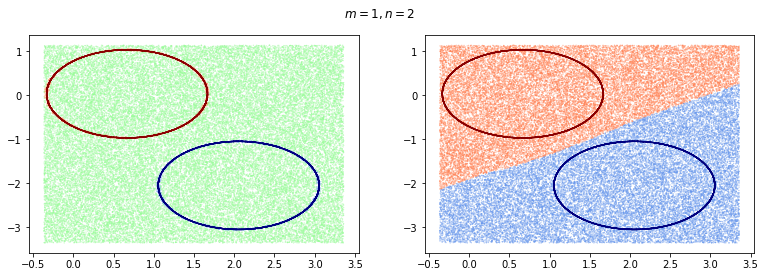

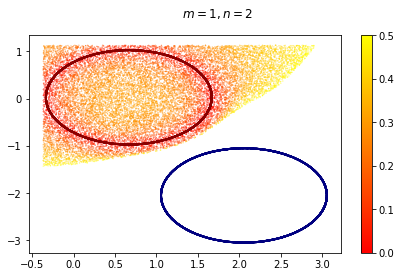

In [12]:
run_analysis_2(dl_dump, stdclf_dump, "val", h=300, thresh=0.025, plot_type="sct", plot_name=plot_name)






In [13]:
yy.shape

NameError: name 'yy' is not defined

In [ ]:
plt.cm.coolwarm[0]

In [ ]:
fig2, ax_array2 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4, 4))
ax_array2[0]